## Homework: Evaluation and Monitoring

In this homework, we'll evaluate the quality of our RAG system.

> It's possible that your answers won't match exactly. If it's the case, select the closest one.

Solution:

* Video: TBA
* Notebook: TBA

## Getting the data

Let's start by getting the dataset. We will use the data we generated in the module.

In particular, we'll evaluate the quality of our RAG system
with [gpt-4o-mini](https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/data/results-gpt4o-mini.csv)


Read it:

```python
url = f'{github_url}?raw=1'
df = pd.read_csv(url)
```

We will use only the first 300 documents:


```python
df = df.iloc[:300]
```


In [127]:
import pandas as pd

github_url = "https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/data/results-gpt4o-mini.csv"

url = f'{github_url}?raw=1'
df = pd.read_csv(url)

df = df.iloc[:300]


## Q1. Getting the embeddings model

Now, get the embeddings model `multi-qa-mpnet-base-dot-v1` from
[the Sentence Transformer library](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#model-overview)

> Note: this is not the same model as in HW3

```bash
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name)
```

Create the embeddings for the first LLM answer:

```python
answer_llm = df.iloc[0].answer_llm
```

What's the first value of the resulting vector?

* -0.42
* -0.22
* -0.02
* 0.21

In [128]:
from sentence_transformers import SentenceTransformer

model_name = "multi-qa-mpnet-base-dot-v1"
embedding_model = SentenceTransformer(model_name)

answer_llm = df.iloc[0].answer_llm

In [129]:
embedding_model.encode(answer_llm)[0]

-0.42244676

## Q2. Computing the dot product


Now for each answer pair, let's create embeddings and compute dot product between them

We will put the results (scores) into the `evaluations` list

What's the 75% percentile of the score?

* 21.67
* 31.67
* 41.67
* 51.67

In [156]:
import numpy as np

answer_orig_vector = np.array([
    embedding_model.encode(text) for text in df.answer_orig])

answer_llm_vector = np.array([
    embedding_model.encode(text) for text in df.answer_llm])


In [157]:

evaluations = np.sum(answer_orig_vector * answer_llm_vector, axis=1)

In [ ]:
!pipenv install seaborn

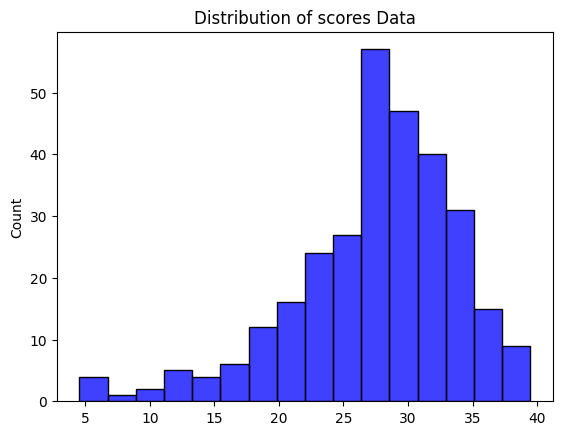

In [158]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Create the plot
sns.histplot(evaluations, color='blue')
plt.title('Distribution of scores Data')
plt.show()

In [159]:
np.percentile(evaluations, 75)

31.674307346343994


## Q3. Computing the cosine

From Q2, we can see that the results are not within the [0, 1] range. It's because the vectors coming from this model are not normalized.

So we need to normalize them.

To do it, we 

* Compute the norm of a vector
* Divide each element by this norm

So, for vector `v`, it'll be `v / ||v||`

In numpy, this is how you do it:

```python
norm = np.sqrt((v * v).sum())
v_norm = v / norm
```

Let's put it into a function and then compute dot product 
between normalized vectors. This will give us cosine similarity

What's the 75% cosine in the scores?

* 0.63
* 0.73
* 0.83
* 0.93





In [160]:
def normalize_vector(v):
    norm = np.sqrt((v * v).sum())
    v_norm = v/norm
    return v_norm

answer_orig_vector_norm = np.array([normalize_vector(v) for v in answer_orig_vector])
answer_llm_vector_norm = np.array([normalize_vector(v) for v in answer_llm_vector])

dot_product = np.sum(answer_orig_vector_norm * answer_llm_vector_norm, axis=1)

In [161]:
np.percentile(dot_product, 75)

0.8362348079681396

<Axes: ylabel='Count'>

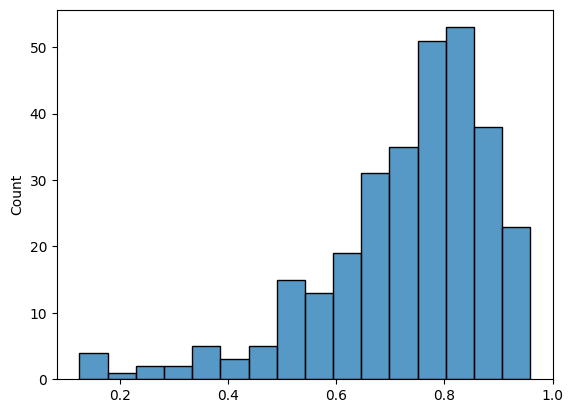

In [162]:
sns.histplot(dot_product)

## Q4. Rouge

Now we will explore an alternative metric - the ROUGE score.  

This is a set of metrics that compares two answers based on the overlap of n-grams, word sequences, and word pairs.

It can give a more nuanced view of text similarity than just cosine similarity alone.

We don't need to implement it ourselves, there's a python package for it:

```bash
pip install rouge
```

(The latest version at the moment of writing is `1.0.1`)

Let's compute the ROUGE score between the answers at the index 10 of our dataframe (`doc_id=5170565b`)

```
from rouge import Rouge
rouge_scorer = Rouge()

scores = rouge_scorer.get_scores(r['answer_llm'], r['answer_orig'])[0]
```

There are three scores: `rouge-1`, `rouge-2` and `rouge-l`, and precision, recall and F1 score for each.

* `rouge-1` - the overlap of unigrams,
* `rouge-2` - bigrams,
* `rouge-l` - the longest common subsequence

What's the F score for `rouge-1`?

- 0.35
- 0.45
- 0.55
- 0.65

In [ ]:
!pipenv install rouge

In [163]:
if (r:= df.iloc[10]).document == "5170565b":
    print("correct doc found!")

r

correct doc found!


answer_llm     Yes, all sessions are recorded, so if you miss...
answer_orig    Everything is recorded, so you won’t miss anyt...
document                                                5170565b
question                    Are sessions recorded if I miss one?
course                                 machine-learning-zoomcamp
Name: 10, dtype: object

In [133]:
from rouge import Rouge
rouge_scorer = Rouge()

scores = rouge_scorer.get_scores(r["answer_llm"], r["answer_orig"])[0]

In [134]:
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

## Q5. Average rouge score

Let's compute the average F-score between `rouge-1`, `rouge-2` and `rouge-l` for the same record from Q4

- 0.35
- 0.45
- 0.55
- 0.65

In [135]:
(scores["rouge-1"]["f"] + scores["rouge-2"]["f"] + scores["rouge-l"]["f"])/3

0.35490034990035496

## Q6. Average rouge score for all the data points

Now let's compute the F-score for all the records and create a dataframe from them.

What's the average F-score in `rouge_2` across all the records?

- 0.10
- 0.20
- 0.30
- 0.40



In [136]:
def calculate_rouge_scores(row):
    scores = rouge_scorer.get_scores(row['answer_llm'], row['answer_orig'])
    return scores

rouge_scores = df.apply(calculate_rouge_scores, axis=1)


In [152]:
rouge2 = pd.DataFrame([rs[0]["rouge-2"] for rs in rouge_scores])


In [155]:
rouge2["f"].mean()

0.20696501983423318

## Submit the results

* Submit your results here: https://courses.datatalks.club/llm-zoomcamp-2024/homework/hw4
* It's possible that your answers won't match exactly. If it's the case, select the closest one.
